In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score, 
    silhouette_samples,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


In [7]:
import os
os.chdir("/Users/veel/Documents/veel_projects/Nuvia/")

In [19]:
# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


CLUSTERS_JSON_PATH = "trending_history_clusters.json"  
EMBEDDINGS_JSON_PATH = "embeddings_data.json"  

def load_clusters_and_embeddings(json_path):
    """Load clusters from JSON and reconstruct embeddings"""
    with open(json_path, 'r', encoding='utf-8') as f:
        clusters_dict = json.load(f)
    
    # clusters_dict format: {"0": [idx1, idx2, ...], "1": [...], "-1": [...]}
    # -1 represents noise points in DBSCAN
    
    return clusters_dict

clusters_from_json = load_clusters_and_embeddings(CLUSTERS_JSON_PATH)
print(f"✓ Loaded clusters from JSON")
print(f"  Number of clusters: {len(clusters_from_json)}")
print(f"  Cluster IDs: {sorted([int(k) for k in clusters_from_json.keys()])}")

✓ Loaded clusters from JSON
  Number of clusters: 8
  Cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7]


In [20]:
def get_cluster_diagnostics(clusters_dict):
    """Compute summary statistics about current clustering"""
    
    total_points = sum(len(indices) for indices in clusters_dict.values())
    num_clusters = len(clusters_dict) - (1 if "-1" in clusters_dict else 0)
    noise_points = len(clusters_dict.get("-1", []))
    
    cluster_sizes = []
    for cid, indices in clusters_dict.items():
        if cid != "-1":
            cluster_sizes.append(len(indices))
    
    diagnostics = {
        "total_points": total_points,
        "num_clusters": num_clusters,
        "noise_points": noise_points,
        "noise_percentage": (noise_points / total_points * 100) if total_points > 0 else 0,
        "avg_cluster_size": np.mean(cluster_sizes) if cluster_sizes else 0,
        "min_cluster_size": min(cluster_sizes) if cluster_sizes else 0,
        "max_cluster_size": max(cluster_sizes) if cluster_sizes else 0,
        "median_cluster_size": np.median(cluster_sizes) if cluster_sizes else 0,
        "cluster_sizes": sorted(cluster_sizes, reverse=True),
    }
    
    return diagnostics

CURRENT CLUSTERING DIAGNOSTICS
Total points:          17
Number of clusters:    8
Noise points:          0 (0.0%)
Avg cluster size:      2.1
Min cluster size:      2
Max cluster size:      3
Median cluster size:   2.0


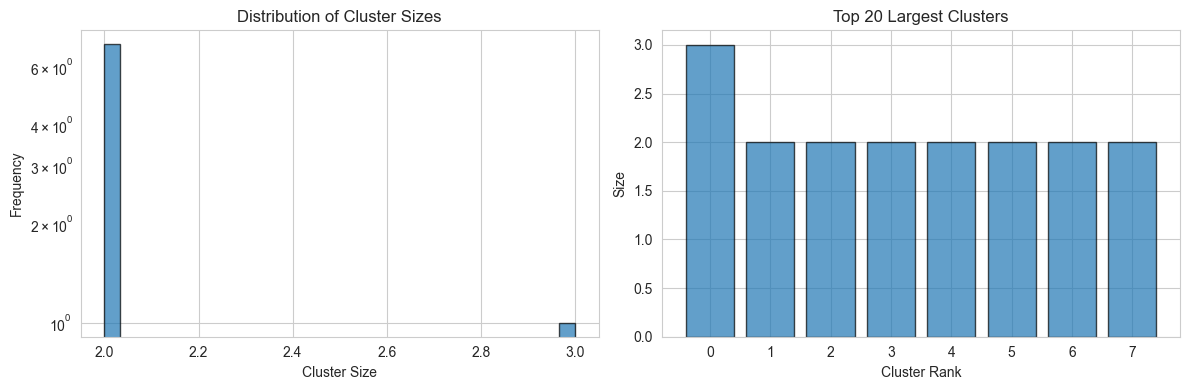

In [21]:
diags = get_cluster_diagnostics(clusters_from_json)

print("=" * 60)
print("CURRENT CLUSTERING DIAGNOSTICS")
print("=" * 60)
print(f"Total points:          {diags['total_points']}")
print(f"Number of clusters:    {diags['num_clusters']}")
print(f"Noise points:          {diags['noise_points']} ({diags['noise_percentage']:.1f}%)")
print(f"Avg cluster size:      {diags['avg_cluster_size']:.1f}")
print(f"Min cluster size:      {diags['min_cluster_size']}")
print(f"Max cluster size:      {diags['max_cluster_size']}")
print(f"Median cluster size:   {diags['median_cluster_size']}")
print("=" * 60)

# Distribution of cluster sizes
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(diags['cluster_sizes'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Sizes')
plt.yscale('log')

plt.subplot(1, 2, 2)
top_20 = sorted(diags['cluster_sizes'], reverse=True)[:20]
plt.bar(range(len(top_20)), top_20, edgecolor='black', alpha=0.7)
plt.xlabel('Cluster Rank')
plt.ylabel('Size')
plt.title('Top 20 Largest Clusters')
plt.tight_layout()
plt.show()

In [22]:
def load_embeddings_and_labels(clusters_dict, embeddings_path):
    """
    Load embeddings and create labels array from cluster dict.
    Assumes embeddings are in order matching cluster indices.
    """
    
    with open(embeddings_path, 'r', encoding='utf-8') as f:
        embedding_data = json.load(f)
    
    embeddings = np.array(embedding_data['embeddings'])
    total_points = len(embeddings)
    
    # Create labels array (-1 for noise, otherwise cluster ID)
    labels = np.full(total_points, -1, dtype=int)
    
    for cluster_id, indices in clusters_dict.items():
        cid = int(cluster_id)
        for idx in indices:
            if idx < total_points:
                labels[idx] = cid
    
    return embeddings, labels

try:
    embeddings, labels = load_embeddings_and_labels(clusters_from_json, "embeddings_data.json")
    print(f"✓ Loaded embeddings: shape {embeddings.shape}")
    print(f"✓ Labels: {np.unique(labels)}")
    
    # Compute silhouette score (excluding noise points)
    non_noise_mask = labels != -1
    if non_noise_mask.sum() > 1:
        silhouette_avg = silhouette_score(embeddings[non_noise_mask], labels[non_noise_mask])
        print(f"\n✓ Silhouette Score (excluding noise): {silhouette_avg:.4f}")
        print(f"  Range: [-1, 1] where 1 = well-separated, -1 = overlapping")
    
    # Davies-Bouldin Index (lower is better)
    if np.unique(labels).size > 1 and non_noise_mask.sum() > 0:
        db_index = davies_bouldin_score(embeddings[non_noise_mask], labels[non_noise_mask])
        print(f"\n✓ Davies-Bouldin Index: {db_index:.4f}")
        print(f"  Lower is better (0 = best)")
    
    # Calinski-Harabasz Index (higher is better)
    if np.unique(labels).size > 1 and non_noise_mask.sum() > 0:
        ch_index = calinski_harabasz_score(embeddings[non_noise_mask], labels[non_noise_mask])
        print(f"\n✓ Calinski-Harabasz Index: {ch_index:.4f}")
        print(f"  Higher is better")

except FileNotFoundError:
    print("⚠ embeddings_data.json not found. See instructions above to save embeddings from process_full_history.py")
    embeddings = None
    labels = None

✓ Loaded embeddings: shape (30, 1536)
✓ Labels: [-1  0  1  2  3  4  5  6  7]

✓ Silhouette Score (excluding noise): 0.6336
  Range: [-1, 1] where 1 = well-separated, -1 = overlapping

✓ Davies-Bouldin Index: 0.5570
  Lower is better (0 = best)

✓ Calinski-Harabasz Index: 10.0857
  Higher is better


## Visualization with t-SNE, UMAP

Computing t-SNE projection (this may take a minute)...


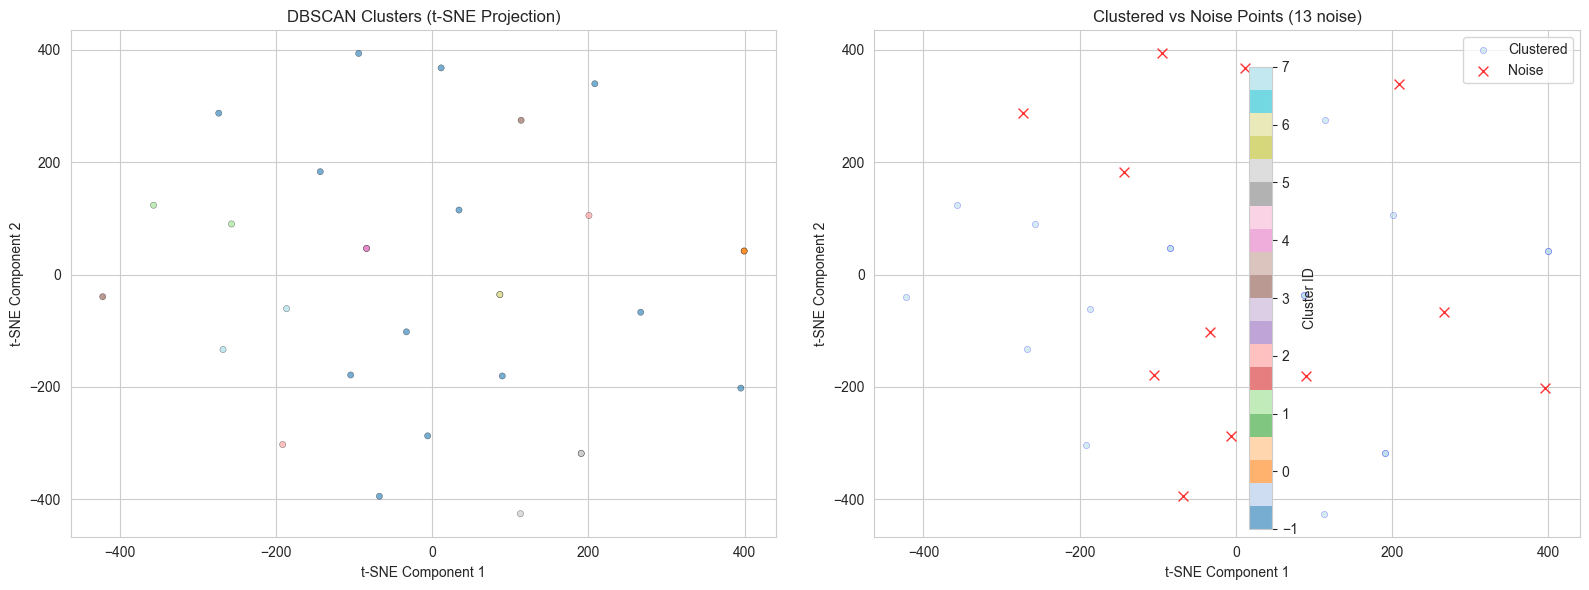

In [25]:
if embeddings is not None:
    # t-SNE dimensionality reduction
    print("Computing t-SNE projection (this may take a minute)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=20, max_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot clusters in 2D space
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Color by cluster
    scatter1 = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                               c=labels, cmap='tab20', s=20, alpha=0.6, 
                               edgecolors='black', linewidth=0.3)
    axes[0].set_xlabel('t-SNE Component 1')
    axes[0].set_ylabel('t-SNE Component 2')
    axes[0].set_title('DBSCAN Clusters (t-SNE Projection)')
    plt.colorbar(scatter1, ax=axes, label='Cluster ID')
    
    # Highlight noise points
    noise_mask = labels == -1
    axes[1].scatter(embeddings_2d[~noise_mask, 0], embeddings_2d[~noise_mask, 1], 
                    c='lightblue', s=20, alpha=0.5, label='Clustered', edgecolors='blue', linewidth=0.3)
    axes[1].scatter(embeddings_2d[noise_mask, 0], embeddings_2d[noise_mask, 1], 
                    c='red', s=50, alpha=0.8, marker='x', label='Noise', linewidth=1)
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')
    axes[1].set_title(f'Clustered vs Noise Points ({noise_mask.sum()} noise)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## Parameter Grid Search

In [28]:
if embeddings is not None:
    # Define parameter ranges to test
    eps_values = np.linspace(0.05, 0.5, 12)  # Adjust based on embedding space
    min_samples_values = [2, 3, 5, 10, 15, 20, 30]
    
    results = []
    
    print("Running DBSCAN parameter grid search...")
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            predicted_labels = dbscan.fit_predict(embeddings)
            
            num_clusters = len(set(predicted_labels)) - (1 if -1 in predicted_labels else 0)
            noise_count = list(predicted_labels).count(-1)
            noise_pct = (noise_count / len(predicted_labels)) * 100
            
            # Compute silhouette only if we have at least 2 clusters
            non_noise_mask = predicted_labels != -1
            silhouette_avg = None
            db_index = None
            
            if num_clusters > 1 and non_noise_mask.sum() > 1:
                try:
                    silhouette_avg = silhouette_score(embeddings[non_noise_mask], 
                                                     predicted_labels[non_noise_mask])
                    db_index = davies_bouldin_score(embeddings[non_noise_mask], 
                                                   predicted_labels[non_noise_mask])
                except:
                    pass
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'num_clusters': num_clusters,
                'noise_count': noise_count,
                'noise_pct': noise_pct,
                'silhouette': silhouette_avg,
                'davies_bouldin': db_index,
            })
    
    results_df = pd.DataFrame(results)
    print(f"✓ Tested {len(results_df)} parameter combinations")
    
    # Show best configurations by different metrics
    print("\n" + "=" * 80)
    print("TOP 10 CONFIGURATIONS BY SILHOUETTE SCORE (higher is better)")
    print("=" * 80)
    valid_silhouette = results_df[results_df['silhouette'].notna()].sort_values('silhouette', ascending=False)
    print(valid_silhouette[['eps', 'min_samples', 'num_clusters', 'noise_pct', 'silhouette']].head(10).to_string())
    
    print("\n" + "=" * 80)
    print("TOP 10 CONFIGURATIONS BY DAVIES-BOULDIN INDEX (lower is better)")
    print("=" * 80)
    valid_db = results_df[results_df['davies_bouldin'].notna()].sort_values('davies_bouldin')
    print(valid_db[['eps', 'min_samples', 'num_clusters', 'noise_pct', 'davies_bouldin']].head(10).to_string())

Running DBSCAN parameter grid search...
✓ Tested 84 parameter combinations

TOP 10 CONFIGURATIONS BY SILHOUETTE SCORE (higher is better)
         eps  min_samples  num_clusters  noise_pct  silhouette
0   0.050000            2             4  73.333333    1.000000
7   0.090909            2             4  73.333333    1.000000
14  0.131818            2             4  73.333333    1.000000
21  0.172727            2             4  73.333333    1.000000
28  0.213636            2             4  73.333333    1.000000
35  0.254545            2             4  73.333333    1.000000
42  0.295455            2             4  73.333333    1.000000
49  0.336364            2             4  73.333333    1.000000
56  0.377273            2             4  73.333333    1.000000
63  0.418182            2             5  66.666667    0.928435

TOP 10 CONFIGURATIONS BY DAVIES-BOULDIN INDEX (lower is better)
         eps  min_samples  num_clusters  noise_pct  davies_bouldin
0   0.050000            2             

## Heatmap for Metrics

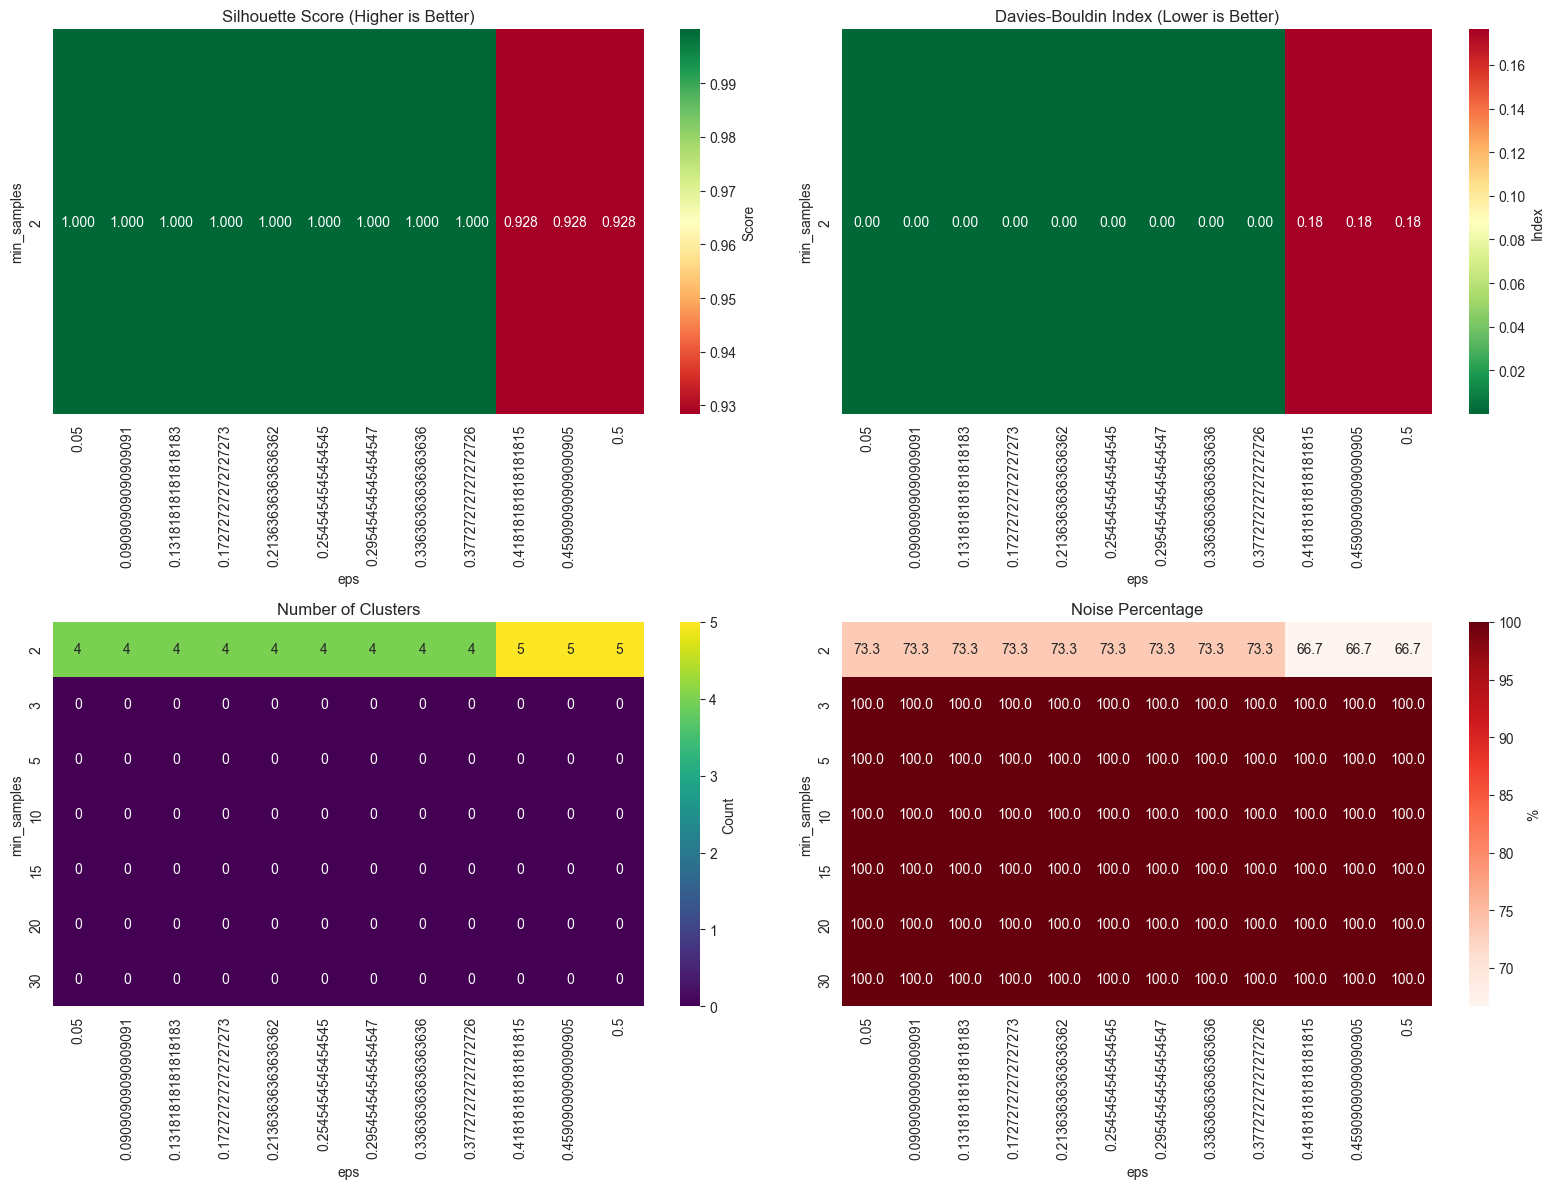

In [27]:
if embeddings is not None:
    # Create heatmaps of metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Pivot data for heatmaps
    silhouette_pivot = results_df.pivot_table(values='silhouette', 
                                              index='min_samples', 
                                              columns='eps')
    db_pivot = results_df.pivot_table(values='davies_bouldin', 
                                      index='min_samples', 
                                      columns='eps')
    num_clusters_pivot = results_df.pivot_table(values='num_clusters', 
                                                index='min_samples', 
                                                columns='eps')
    noise_pct_pivot = results_df.pivot_table(values='noise_pct', 
                                             index='min_samples', 
                                             columns='eps')
    
    # Plot heatmaps
    sns.heatmap(silhouette_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0], 
                cbar_kws={'label': 'Score'})
    axes[0, 0].set_title('Silhouette Score (Higher is Better)')
    axes[0, 0].set_xlabel('eps')
    axes[0, 0].set_ylabel('min_samples')
    
    sns.heatmap(db_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[0, 1], 
                cbar_kws={'label': 'Index'})
    axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)')
    axes[0, 1].set_xlabel('eps')
    axes[0, 1].set_ylabel('min_samples')
    
    sns.heatmap(num_clusters_pivot, annot=True, fmt='.0f', cmap='viridis', ax=axes[1, 0], 
                cbar_kws={'label': 'Count'})
    axes[1, 0].set_title('Number of Clusters')
    axes[1, 0].set_xlabel('eps')
    axes[1, 0].set_ylabel('min_samples')
    
    sns.heatmap(noise_pct_pivot, annot=True, fmt='.1f', cmap='Reds', ax=axes[1, 1], 
                cbar_kws={'label': '%'})
    axes[1, 1].set_title('Noise Percentage')
    axes[1, 1].set_xlabel('eps')
    axes[1, 1].set_ylabel('min_samples')
    
    plt.tight_layout()
    plt.show()
